# Volatility modeling

## Content

- Data
    - Upload and visualize data
    - Preprocess prices and transform to returns
    - Plot histograms and Q-Q plots
    
    
- Modelling volatility
    - GARCH
    - Filtered HS
    
    
- Calculating VaR curve using volatility models
    - Filtered Historical Simulation
    - Parametric estimation
    
    
- Backtesting VaR curve
    - Bernoulli coverage test
    - Independence test
    


In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt
#plt.style.use("bmh")
#plt.rcParams['font.family'] = 'DejaVu Sans'

import warnings
warnings.filterwarnings("ignore")

## Data

### Upload and visualize data

Get the S&P 500 quotes

In [2]:
sp500_raw = pd.read_csv('data/SP500 Prices.csv')
if 'Unnamed: 0' in sp500_raw.columns:
    sp500_raw = sp500_raw.drop('Unnamed: 0', axis=1)
sp500_raw = sp500_raw.rename(columns={'datadate': 'date'})
sp500_raw['date'] = pd.to_datetime(sp500_raw['date'])

In [3]:
prices = sp500_raw.rename({'date': 'date', 'prccddiv': 'Close'}, axis=1).set_index('date')
prices['Returns'] = prices['Close'].pct_change()

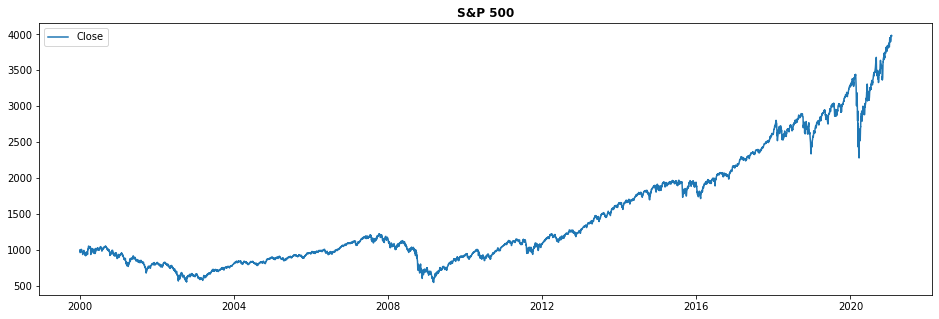

In [4]:
plot_fields =  ['Close']

fig = plt.figure(figsize=(16, 5))

plt.plot(prices[plot_fields]/2)
plt.legend(plot_fields)

plt.title("S&P 500", weight="bold")

plt.show()

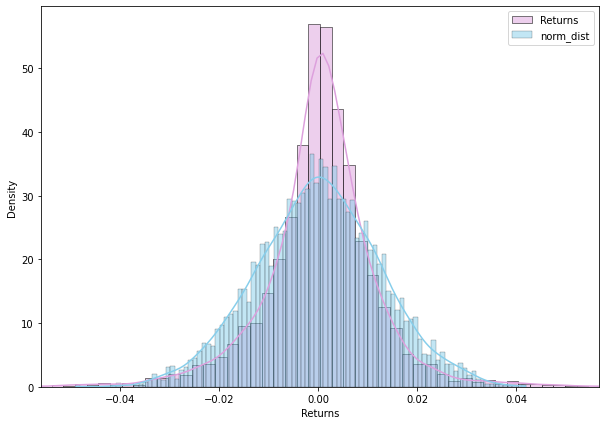

In [5]:
data = prices

FACTOR = 'Returns'

fig, axs = plt.subplots(1, 1, figsize=(10, 7))

sns.histplot(data=data[FACTOR], kde=True, stat='density', color='plum', label=FACTOR, ax=axs, bins=100)
sns.histplot(data=(pd.Series(data[FACTOR]).std() * np.random.randn(len(data[FACTOR])) + pd.Series(data[FACTOR]).mean()), 
             bins=100, 
             kde=True, 
             color='skyblue', 
             stat='density',
             ax=axs,
             label='norm_dist')
axs.legend()
axs.set_xlim(pd.Series(data[FACTOR]).mean() - 4.5*pd.Series(data[FACTOR]).std(), 
            pd.Series(data[FACTOR]).mean() + 4.5*pd.Series(data[FACTOR]).std())
plt.show()

### Preprocess prices and transform to returns

In [6]:
prices.index = prices.index.to_period(freq='d')

price = prices['Close']
ret = price.pct_change()
ret = ret.dropna()

ret

date
2000-01-04   -0.038312
2000-01-05    0.002010
2000-01-06    0.001155
2000-01-07    0.027090
2000-01-10    0.011209
                ...   
2021-01-20    0.013936
2021-01-21    0.000401
2021-01-22   -0.003001
2021-01-25    0.003616
2021-01-26   -0.001483
Freq: D, Name: Close, Length: 5299, dtype: float64

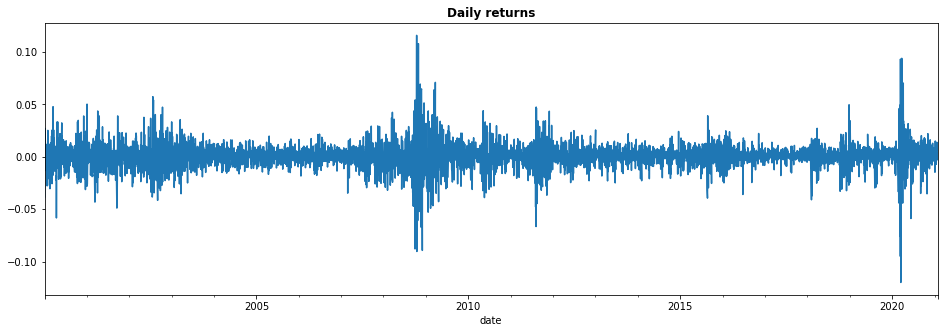

In [7]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
plt.title("Daily returns", weight="bold")

plt.show()

## VaR via Historical Simulation

In [8]:
def calculate_VaR_HS(ret, alpha=0.05):

    return ret.quantile(alpha)

def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [9]:
alpha = 0.1

In [10]:
VaR_HS = calc_VaR(ret, calculate_VaR_HS, L_history=252, level=alpha)

VaR_HS

date
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
2000-01-10         NaN
                ...   
2021-01-20   -0.018512
2021-01-21   -0.018512
2021-01-22   -0.018512
2021-01-25   -0.018512
2021-01-26   -0.018512
Freq: D, Name: calculate_VaR_HS, Length: 5299, dtype: float64

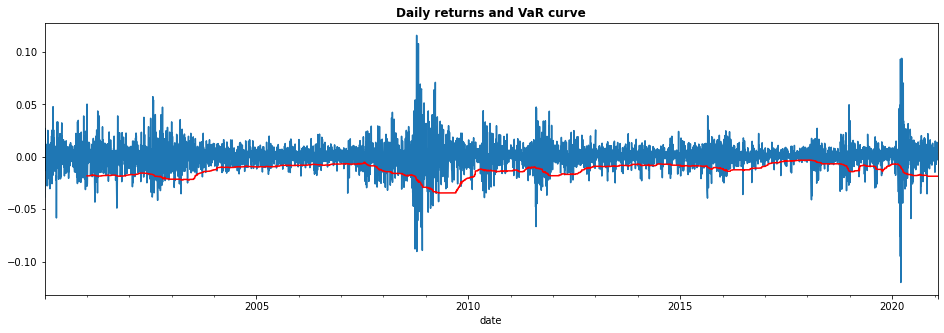

In [11]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_HS.plot(color='r')

plt.title("Daily returns and VaR curve", weight="bold")

plt.show()

## Volatility

### Simple case of Moving average estimation

Conditional volatility is the average sum of squared returns over the estimation window:

$$\hat{\sigma_{t}^2} = \frac{1}{W_e}\sum_{k=1}^{W_e}r_{t-k}^2$$

**Estimate variance using moving average with estimation window of 30 days**


In [12]:
w_est = 30

variance_ma = np.full(ret.size, np.nan)

for i in range(w_est, len(ret)):
    
    history = ret[i - w_est: i]
    
    variance_ma[i] = np.sum(np.power(history, 2)) / w_est
    
variance_ma = pd.Series(variance_ma, index=ret.index)

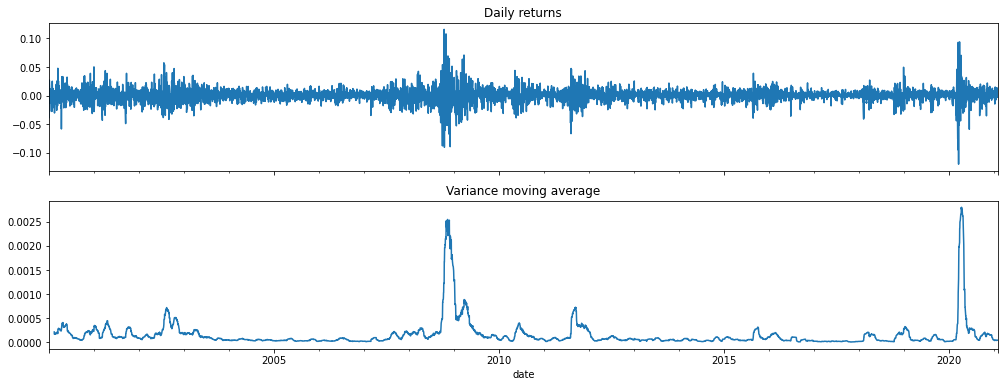

In [13]:
fig = plt.figure(figsize=(17, 6))

plt1 = fig.add_subplot(2,1,1)
plt2 = fig.add_subplot(2,1,2)

ret.plot(ax=plt1.axes)
plt1.set_title('Daily returns')

variance_ma.plot(ax=plt2.axes)
plt2.set_title('Variance moving average')

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

### GARCH models

Here we start assuming dependency between $r_t$ and $r_{t+h}$, and we will use Conditional volatility models. Facts motivating these models:
1. Returns are not linearly autocorrelated
2. The ACF of squared returns dies out exponentially
3. Volatility is time-varying

Main assumption: Conditional returns are iid normally distributed with time-varying variance

$$r_{t+1} = \mu_t  + \sqrt{h_t}\epsilon_t \text{  with  } \epsilon_t \sim N(0, 1)$$

$$\mu_{t+1} = F(r_t, r_{t-1}, ...)$$

$$h_{t+1} = G(r^2_t, r^2_{t-1}, ...)$$


For example, ARMA-GARCH model could be written as:

$$\mu_{t+1} = a + \sum_0^k c_ir_{t-i} + \sum_0^m d_i\epsilon_{t-i}$$

$$h_{t+1} = \omega + \sum_0^p \alpha_ir^2_{t-i} + \sum_0^q \beta_ih_{t-i}$$


Also, $\epsilon_t$ can have some other distribution $\epsilon_t \sim F(x; \theta)$


#### GARCH with parametric distribution of residuals

In [14]:
# https://arch.readthedocs.io/en/latest/univariate/introduction.html
# !pip install arch



**Fit a model**

Note: for numerical optimization purposes, it is better to scale your returns series to a scale of one and re-scale it after

**Parameters to use:**

- `mean` and `lags` -- to specify model for mean
- `vol`, `p`, `q` and `o` -- to specify model for variance
- `dist` -- to specify distribution for normalized residuals

In [15]:
from arch import arch_model 

mdl = arch_model(ret*100,
                    mean='Constant', lags=1,   # mean = Constant, ARX, HARX + number of lags
                    vol='Garch', p=1, o=1, q=1,   # vol = GARCH, EGARCH, HARCH + number of lags
                    dist='normal')
res = mdl.fit()


res

Iteration:      1,   Func. Count:      7,   Neg. LLF: 5579018753.016566
Iteration:      2,   Func. Count:     17,   Neg. LLF: 22957578244.76491
Iteration:      3,   Func. Count:     25,   Neg. LLF: 13562.03539746421
Iteration:      4,   Func. Count:     34,   Neg. LLF: 7452.230560372979
Iteration:      5,   Func. Count:     41,   Neg. LLF: 36875.11205908054
Iteration:      6,   Func. Count:     49,   Neg. LLF: 7211.628559095769
Iteration:      7,   Func. Count:     56,   Neg. LLF: 7193.950391876699
Iteration:      8,   Func. Count:     63,   Neg. LLF: 7189.5513257302755
Iteration:      9,   Func. Count:     70,   Neg. LLF: 7205.817969771528
Iteration:     10,   Func. Count:     78,   Neg. LLF: 7189.205237330917
Iteration:     11,   Func. Count:     84,   Neg. LLF: 7189.205131754173
Iteration:     12,   Func. Count:     90,   Neg. LLF: 7189.205130567268
Iteration:     13,   Func. Count:     95,   Neg. LLF: 7189.205130567205
Optimization terminated successfully    (Exit mode 0)
         

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -7189.21
Distribution:                  Normal   AIC:                           14388.4
Method:            Maximum Likelihood   BIC:                           14421.3
                                        No. Observations:                 5299
Date:                Sun, May 12 2024   Df Residuals:                     5294
Time:                        00:32:04   Df Model:                            5
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0303  1.092e-02      2.779  5.458e-03 [8.

Here we can see fitted conditional volatility and standartized residuals

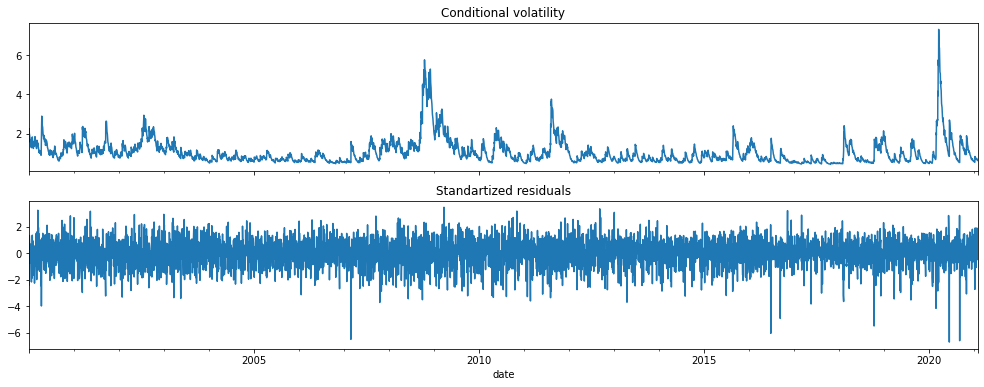

In [16]:
fig = plt.figure(figsize=(17, 6))

plt1 = fig.add_subplot(2,1,1)
plt2 = fig.add_subplot(2,1,2)

res.conditional_volatility.plot(ax=plt1.axes)
plt1.set_title('Conditional volatility')

(res.resid / res.conditional_volatility).plot(ax=plt2.axes)
plt2.set_title('Standartized residuals')

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

**Forecast of conditional mean and variance**

In [17]:
my_forecast = res.forecast(horizon=5)

print(my_forecast.mean.tail(4))
print(my_forecast.variance.tail(4))

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2021-01-21       NaN       NaN       NaN       NaN       NaN
2021-01-22       NaN       NaN       NaN       NaN       NaN
2021-01-25       NaN       NaN       NaN       NaN       NaN
2021-01-26  0.030343  0.030343  0.030343  0.030343  0.030343
                 h.1       h.2       h.3       h.4     h.5
date                                                      
2021-01-21       NaN       NaN       NaN       NaN     NaN
2021-01-22       NaN       NaN       NaN       NaN     NaN
2021-01-25       NaN       NaN       NaN       NaN     NaN
2021-01-26  0.393333  0.407486  0.421362  0.434965  0.4483


**Implement Filtered Historical Simulation**

Steps:
- fit a model
- get Standartized residuals
- forecast mean and variance one step ahead
- use forecasts and Standartized residuals to get a distribution for Conditional residuals
- calculate VaR as quantile

In [18]:
# fit the model with normal ditribution

mdl = arch_model(ret * 100,
                    mean='Constant', lags=1,   # mean = Constant, ARX, HARX + number of lags
                    vol='Garch', p=1, o=1, q=1,   # vol = GARCH, EGARCH, HARCH + number of lags
                    dist='normal')

res = mdl.fit(disp='off')


# get Standartized residuals
stand_residuals = res.resid / res.conditional_volatility
stand_residuals = stand_residuals.dropna()


# forecast mean and variance one step ahead
forecasts = res.forecast(horizon=1)
cond_mean = float(forecasts.mean.iloc[-1])
cond_var = float(forecasts.variance.iloc[-1])


# conditional stand_residuals
conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
conditional_sr = conditional_sr / 100

# calculate VaR as quantile
VaR_FHS = conditional_sr.quantile(alpha)

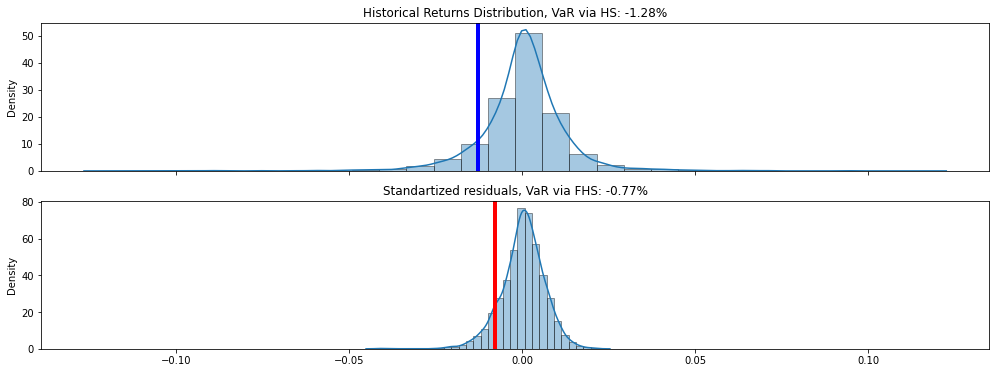

In [19]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(17, 6))

VaR_HS_10 = np.quantile(ret, alpha)

sns.distplot(ret, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'}, ax=ax[0])
ax[0].set_title('Historical Returns Distribution, VaR via HS: {:.2f}%'.format(100*VaR_HS_10))
ax[0].axvline(x=VaR_HS_10, linewidth=4, color="b")

sns.distplot(conditional_sr, hist=True, kde=True, 
             bins=30, norm_hist=True,
             hist_kws={'edgecolor':'black'}, ax=ax[1])
ax[1].set_title('Standartized residuals, VaR via FHS: {:.2f}%'.format(100*VaR_FHS))
ax[1].axvline(x=VaR_FHS, linewidth=4, color="r")

for ax in fig.get_axes():
    ax.label_outer()

plt.show()

**Wrap everything into functions and do a backtest**

In [20]:
def calculate_VaR_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()
    
    dist = 'skewstudent'
    
    am = arch_model(scaling_const * returns,
                    mean='HARX', lags=1,   # mean = Constant, ARX, HARX + number of lags
                    vol='Garch', p=1, o=1, q=1,   # vol = GARCH, EGARCH, HARCH + number of lags
                    dist='normal')
    
    res = am.fit(update_freq=0, disp='off')
    
    forecasts = res.forecast(horizon=1)
    
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])
    
    if disp == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])
        
    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const
    
    return VaR_garch_forecast
        

def calculate_VaR_FHS(returns, alpha):
    
    scaling_const = 10.0 / returns.std()
    
    mdl = arch_model(scaling_const * returns,
                    mean='HARX', lags=1,   # mean = Constant, ARX, HARX + number of lags
                    vol='Garch', p=1, o=1, q=1,   # vol = GARCH, EGARCH, HARCH + number of lags
                    dist='normal')
    
    res = mdl.fit(disp='off')
    
    # get Standartized residuals
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()
    
    # forecast mean and variance one step ahead
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])
    
    
    # conditional stand_residuals
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    #conditional_sr = cond_mean + np.sqrt(cond_var) * q
    conditional_sr = conditional_sr / scaling_const
    
    # calculate VaR as quantile
    VaR_FHS = conditional_sr.quantile(alpha)

    return VaR_FHS

In [21]:
VaR_FHS = calc_VaR(ret, calculate_VaR_FHS, L_history=252, level=alpha)

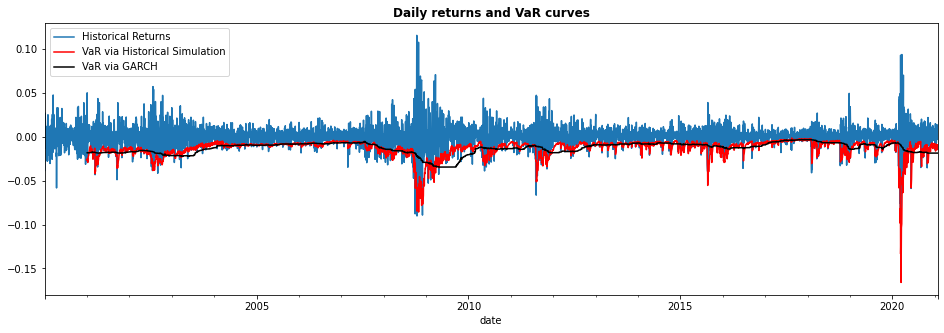

In [22]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
VaR_FHS.plot(color='r')
VaR_HS.plot(color='black')

plt.title("Daily returns and VaR curves", weight="bold")

plt.legend(['Historical Returns',
            'VaR via Historical Simulation',
           'VaR via GARCH'
           ])

plt.show()

## Backtesting VaR

**Use functions below to test VaR curves obtained by using Historical simulation and Filtered HS**

In [23]:
def bern_test(p, v):
    
    lv = len(v)
    sv = sum(v)
    al = np.log(p)*sv + np.log(1-p)*(lv-sv)
    
    bl = np.log(sv/lv)*sv + np.log(1-sv/lv)*(lv-sv)
    
    return (-2*(al-bl))


def ind_test(V):
    
    J = np.full([len(V),4], 0)
    for i in range(1,len(V)-1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)
        
    V_00 = sum(J[:,0])
    V_01 = sum(J[:,1])
    V_10 = sum(J[:,2])
    V_11 = sum(J[:,3])
    p_00=V_00/(V_00+V_01)
    p_01=V_01/(V_00+V_01)
    p_10=V_10/(V_10+V_11)
    p_11=V_11/(V_10+V_11)
    hat_p = (V_01+V_11)/(V_00+V_01+V_10+V_11)
    al = np.log(1-hat_p)*(V_00+V_10) + np.log(hat_p)*(V_01+V_11)
    bl = np.log(p_00)*V_00 + np.log(p_01)*V_01 + np.log(p_10)*V_10 + np.log(p_11)*V_11
    
    return (-2*(al-bl))

In [24]:
def backtest_results(ret, var_curve, alpha, significance=0.95):
    
    idx = var_curve.notna()
    
    violations = ret[idx] < var_curve[idx]
    
    coverage = bern_test(p=alpha, v=violations) < ss.chi2.ppf(significance, 1)
    independence = ind_test(violations) < ss.chi2.ppf(significance, 1)
        
    print('Target share of violations: {:.2f}%'.format(100*alpha))
    print('Observed share of violations: {:.2f}%'.format(100*violations.mean()))
    
    print('')
    
    if coverage:
        print('Test for coverage is passed')
    else:
        print('Test for coverage isn\'t passed')
        
    print('')
        
    if independence:
        print('Test for independence is passed')
    else:
        print('Test for independence isn\'t passed')

In [25]:
backtest_results(ret, VaR_HS, alpha)

Target share of violations: 10.00%
Observed share of violations: 10.36%

Test for coverage is passed

Test for independence isn't passed


In [26]:
backtest_results(ret, VaR_FHS, alpha)

Target share of violations: 10.00%
Observed share of violations: 10.20%

Test for coverage is passed

Test for independence is passed


**Both VaR curves pass coverage test, but VaR via historical simulation fails to pass independence test as it does not include volatility clustering, so during unstable periods VaR via historical simulation is violated more often than calm periods. Unlike HS, VaR via Filtered HS (using GARCH) passes the independence test, proving that violations occur independently of each other**